### *CELL 1 — Markdown (purpose + outputs)*

# Notebook 04 — Inflow Reconstruction Performance (Objective 1 Results)

## Purpose
Quantitatively evaluate the tributary inflow reconstruction methods developed in Notebook 03,
and produce thesis-ready performance tables and figures.

## What is evaluated?
- For tributaries reconstructed using regression (ridge_rain_seasonality_log1p):
  - Compute performance metrics on a time-based train/test split
  - Compare observed vs simulated monthly flows during overlap months only

- For tributaries reconstructed using climatology_scaled_by_rain:
  - No overlap exists in the study window; therefore, direct observed-vs-simulated evaluation is not possible
  - We report method rationale and provide plausibility checks (distribution + seasonality)

## Key metrics (monthly)
- RMSE (m³/s)
- NSE (Nash–Sutcliffe Efficiency)
- KGE (Kling–Gupta Efficiency)
- Bias (%)
- R²

## Outputs
Tables saved to outputs/tables/
- 04_reconstruction_performance_train_test.csv
- 04_method_summary.csv
- 04_total_qin_summary.csv

Figures saved to outputs/figures/
- 04_scatter_obs_vs_sim_*.png
- 04_timeseries_obs_vs_sim_best_worst.png
- 04_total_qin_monthly_daily.png

## Thesis link (Chapter 4)
This notebook produces Objective 1 results: inflow reconstruction accuracy and readiness for water balance modeling.


### *CELL 2 — Imports + paths*

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TABLE_DIR = PROJECT_ROOT / "outputs" / "tables"

for folder in [PROCESSED_DIR, FIG_DIR, TABLE_DIR]:
    folder.mkdir(parents=True, exist_ok=True)


AUDIT_DAILY_PATH = PROCESSED_DIR / "audit_daily_core_variables.csv"
TRIB_WIDE_PATH = PROCESSED_DIR / "tributaries_monthly_wide.csv"
RECON_MONTHLY_PATH = PROCESSED_DIR / "tributaries_monthly_reconstructed.csv"
METHODS_PATH = TABLE_DIR / "03_reconstruction_methods.csv"
OVERLAP_PATH = TABLE_DIR / "03_tributary_overlap_classification.csv"
QIN_DAILY_PATH = PROCESSED_DIR / "Qin_total_daily_2001_2021.csv"


### *CELL 3 — Robust CSV loader (handles “Unnamed: 0” index)*

In [7]:
def load_csv_with_date_index(path: Path) -> pd.DataFrame:
    """Load CSV and robustly detect date index column."""
    df = pd.read_csv(path)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)
        df = df.set_index("date")
        return df.sort_index()

    for c in ["Unnamed: 0", "index", "Date"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            df = df.set_index(c)
            df.index.name = "date"
            return df.sort_index()

    first = df.columns[0]
    df[first] = pd.to_datetime(df[first], errors="coerce", infer_datetime_format=True)
    df = df.set_index(first)
    df.index.name = "date"
    return df.sort_index()


### *CELL 4 — Load all required datasets*

In [8]:
audit_daily = load_csv_with_date_index(AUDIT_DAILY_PATH)
trib_wide = load_csv_with_date_index(TRIB_WIDE_PATH)
recon_monthly = load_csv_with_date_index(RECON_MONTHLY_PATH)

methods = pd.read_csv(METHODS_PATH)
overlap = pd.read_csv(OVERLAP_PATH)

qin_daily = load_csv_with_date_index(QIN_DAILY_PATH)

print("audit_daily:", audit_daily.shape, audit_daily.index.min().date(), audit_daily.index.max().date())
print("trib_wide:", trib_wide.shape, trib_wide.index.min().date(), trib_wide.index.max().date())
print("recon_monthly:", recon_monthly.shape, recon_monthly.index.min().date(), recon_monthly.index.max().date())
print("methods rows:", len(methods))
print("qin_daily:", qin_daily.shape, qin_daily.index.min().date(), qin_daily.index.max().date())


audit_daily: (7422, 4) 2001-01-01 2021-04-27
trib_wide: (708, 15) 1965-01-01 2023-12-01
recon_monthly: (244, 16) 2001-01-01 2021-04-01
methods rows: 15
qin_daily: (7422, 1) 2001-01-01 2021-04-27


C:\Users\Nelson\AppData\Local\Temp\ipykernel_34348\3982290770.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34348\3982290770.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34348\3982290770.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict

### *CELL 5 — Define study window + monthly index (same as Notebook 01)*

In [9]:
def ensure_month_start_index(obj):
    idx = pd.to_datetime(obj.index).to_period("M").to_timestamp(how="start")
    out = obj.copy()
    out.index = idx
    # merge duplicates if any
    if hasattr(out, "groupby"):
        out = out.groupby(out.index).mean(numeric_only=True)
    return out.sort_index()

trib_wide = ensure_month_start_index(trib_wide)
recon_monthly = ensure_month_start_index(recon_monthly)

print("Monthly window:", monthly_idx.min().date(), "to", monthly_idx.max().date(), "n=", len(monthly_idx))


Monthly window: 2001-01-01 to 2021-04-01 n= 244


### *CELL 6 — Build rainfall predictors again (for re-fitting & test evaluation)*

`This ensures Notebook 04 is independent and reproducible`

In [10]:
def pick_rainfall_column(df: pd.DataFrame) -> str:
    """Pick rainfall column from likely names."""
    for c in ["rainfall_mm", "Average_pcp_mm/day", "Average_pcp"]:
        if c in df.columns:
            return c
    raise ValueError(f"Rainfall column not found. Columns: {df.columns.tolist()}")


def build_monthly_rain_predictors(rain_daily_mm: pd.Series, idx_monthly: pd.DatetimeIndex) -> pd.DataFrame:
    """Monthly predictors: totals + lags + seasonal dummies."""
    rain_m = rain_daily_mm.resample("MS").sum(min_count=1).reindex(idx_monthly)

    x = pd.DataFrame(index=idx_monthly)
    x["rain_m0"] = rain_m
    x["rain_m1"] = rain_m.shift(1)
    x["rain_m2"] = rain_m.shift(2)

    # Fill lags to avoid sklearn NaN errors (critical fix)
    x[["rain_m1", "rain_m2"]] = x[["rain_m1", "rain_m2"]].fillna(0.0)

    month_dummies = pd.get_dummies(idx_monthly.month, prefix="mo", drop_first=True)
    month_dummies.index = idx_monthly
    x = pd.concat([x, month_dummies], axis=1)

    return x


rain_col = pick_rainfall_column(audit_daily)
rain_daily = audit_daily[rain_col].loc[STUDY_START:STUDY_END]

X_rain = build_monthly_rain_predictors(rain_daily, monthly_idx)
X_rain.head()


,rain_m0,rain_m1,rain_m2,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
2001-01-01,112.106991,0.000000,0.000000,False,False,False,False,False,False,False,False,False,False,False
2001-02-01,65.338277,112.106991,0.000000,True,False,False,False,False,False,False,False,False,False,False
2001-03-01,179.856445,65.338277,112.106991,False,True,False,False,False,False,False,False,False,False,False
2001-04-01,214.352516,179.856445,65.338277,False,False,True,False,False,False,False,False,False,False,False
2001-05-01,182.640783,214.352516,179.856445,False,False,False,True,False,False,False,False,False,False,False


### *CELL 7 — Hydrology metrics (NSE, KGE, Bias, RMSE, R²)*

In [11]:
def rmse(obs: np.ndarray, sim: np.ndarray) -> float:
    return float(np.sqrt(mean_squared_error(obs, sim)))


def nse(obs: np.ndarray, sim: np.ndarray) -> float:
    denom = np.sum((obs - np.mean(obs)) ** 2)
    if denom == 0:
        return np.nan
    return float(1 - np.sum((obs - sim) ** 2) / denom)


def kge(obs: np.ndarray, sim: np.ndarray) -> float:
    """
    Kling-Gupta Efficiency (2009 form).
    KGE = 1 - sqrt((r-1)^2 + (alpha-1)^2 + (beta-1)^2)
    """
    if len(obs) < 2:
        return np.nan

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs) if np.std(obs) > 0 else np.nan
    beta = np.mean(sim) / np.mean(obs) if np.mean(obs) != 0 else np.nan

    if np.isnan(r) or np.isnan(alpha) or np.isnan(beta):
        return np.nan

    return float(1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2))


def bias_percent(obs: np.ndarray, sim: np.ndarray) -> float:
    denom = np.mean(obs)
    if denom == 0:
        return np.nan
    return float(100.0 * (np.mean(sim) - np.mean(obs)) / denom)


def r2(obs: np.ndarray, sim: np.ndarray) -> float:
    if len(obs) < 2:
        return np.nan
    r = np.corrcoef(obs, sim)[0, 1]
    return float(r ** 2)


### *CELL 8 — Refit ridge model per tributary and compute Train/Test performance*

`We’ll use time-based split on overlap months:`

`train = first 70%`

`test = last 30%`

In [13]:
def fit_ridge_log1p(y: pd.Series, X: pd.DataFrame, alpha: float = 2.0) -> Ridge:
    """Fit ridge on log1p(y) with no NaNs in X and y."""
    yv = y.values.astype(float)
    yv = np.log1p(np.clip(yv, 0.0, None))

    model = Ridge(alpha=alpha)
    model.fit(X.values, yv)
    return model


def predict_ridge_log1p(model: Ridge, X: pd.DataFrame) -> np.ndarray:
    """Predict and invert log1p transform."""
    y_hat_t = model.predict(X.values)
    y_hat = np.expm1(y_hat_t)
    return np.clip(y_hat, 0.0, None)


ridge_tributaries = methods.loc[methods["method"].str.startswith("ridge"), "tributary"].tolist()
clim_tributaries = methods.loc[methods["method"].str.contains("climatology"), "tributary"].tolist()

results: List[dict] = []

for trib in ridge_tributaries:
    y_obs_full = trib_wide[trib].reindex(monthly_idx)
    y_sim_full = recon_monthly[trib].reindex(monthly_idx)

    # overlap months where observed exists
    mask = (
    y_obs_full.notna() &
    X_rain.notna().all(axis=1) &
    y_obs_full.index.isin(X_rain.index)
)
    y_obs = y_obs_full.loc[mask]
    X = X_rain.loc[mask]

    if len(y_obs) < 24:
        continue

    # Time-based split
    split = int(np.floor(0.7 * len(y_obs)))
    train_idx = y_obs.index[:split]
    test_idx = y_obs.index[split:]

    model = fit_ridge_log1p(y_obs.loc[train_idx], X.loc[train_idx], alpha=2.0)

    y_train_sim = predict_ridge_log1p(model, X.loc[train_idx])
    y_test_sim = predict_ridge_log1p(model, X.loc[test_idx])

    y_train_obs = y_obs.loc[train_idx].values
    y_test_obs = y_obs.loc[test_idx].values

    results.append(
        {
            "tributary": trib,
            "n_train": len(train_idx),
            "n_test": len(test_idx),
            "rmse_train": rmse(y_train_obs, y_train_sim),
            "rmse_test": rmse(y_test_obs, y_test_sim),
            "nse_train": nse(y_train_obs, y_train_sim),
            "nse_test": nse(y_test_obs, y_test_sim),
            "kge_train": kge(y_train_obs, y_train_sim),
            "kge_test": kge(y_test_obs, y_test_sim),
            "bias_train_pct": bias_percent(y_train_obs, y_train_sim),
            "bias_test_pct": bias_percent(y_test_obs, y_test_sim),
            "r2_train": r2(y_train_obs, y_train_sim),
            "r2_test": r2(y_test_obs, y_test_sim),
        }
    )

perf_df = pd.DataFrame(results).sort_values("nse_test", ascending=False).reset_index(drop=True)
perf_df.to_csv(TABLE_DIR / "04_reconstruction_performance_train_test.csv", index=False)

perf_df


,tributary,n_train,n_test,rmse_train,rmse_test,nse_train,nse_test,kge_train,kge_test,bias_train_pct,bias_test_pct,r2_train,r2_test
0,Sio_Malaba,142,62,4.002430,4.965979,0.721615,0.588745,0.787714,0.756803,-6.599358,15.621648,0.732952,0.699345
1,Mori,154,66,2.109945,3.013573,0.717291,0.567960,0.760131,0.724412,-7.601160,14.592948,0.726075,0.706933
2,Awach,154,66,2.172136,2.856047,0.587124,0.557590,0.678146,0.694546,-5.201646,3.036898,0.599200,0.565741
3,Magogo,154,66,2.039592,2.964228,0.730237,0.556321,0.812516,0.778120,-2.850443,9.946822,0.734590,0.653403
4,Sondu,154,66,24.326595,17.662826,0.315629,0.535558,0.407683,0.771239,-12.108876,6.097519,0.347841,0.614187
5,Simiyu,151,65,6.306162,8.387995,0.365149,0.468750,0.478621,0.494044,-13.202064,-12.151819,0.408423,0.505630
6,Mbalangeti,100,44,2.161613,3.278994,0.773590,0.436254,0.853528,0.647106,-4.591152,-9.596212,0.779843,0.483035
7,Rwizi,83,36,8.614391,10.481623,0.258240,-0.434555,0.233940,-0.421691,-20.188055,-16.583826,0.321807,0.080904
8,Kagera,134,58,171.362480,87.914977,0.176147,-0.549575,0.235223,0.347092,-15.458515,-6.194717,0.222451,0.335441
9,Grumeti,125,55,2.890081,4.900242,0.640553,-0.706694,0.735140,0.394811,-3.137174,-15.508242,0.647065,0.220597


### *CELL 9 — Method summary table (for Chapter 4)*

In [14]:
method_summary = (
    methods.merge(overlap, on="tributary", how="left")
    .sort_values(["method", "overlap_months"], ascending=[True, False])
    .reset_index(drop=True)
)

method_summary.to_csv(TABLE_DIR / "04_method_summary.csv", index=False)
method_summary


,tributary,method,rmse,n_train,n_pred,overlap_months,trainable_regression
0,Nyando,climatology_scaled_by_rain,NaN,0,244,0,False
1,Nzoia,climatology_scaled_by_rain,NaN,0,244,0,False
2,Yala,climatology_scaled_by_rain,NaN,0,244,0,False
3,Awach,ridge_rain_seasonality_log1p,2.391997,220,244,220,True
4,Magogo,ridge_rain_seasonality_log1p,2.305615,220,244,220,True
5,Migori,ridge_rain_seasonality_log1p,35.407310,220,244,220,True
6,Mori,ridge_rain_seasonality_log1p,2.238314,220,244,220,True
7,Sondu,ridge_rain_seasonality_log1p,22.377768,220,244,220,True
8,Simiyu,ridge_rain_seasonality_log1p,6.888441,216,244,216,True
9,Sio_Malaba,ridge_rain_seasonality_log1p,4.362470,204,244,204,True


### *CELL 10 — Scatter plots: Observed vs Simulated (TEST months only)*

`Note:` This is the classic thesis figure.

In [15]:
def scatter_obs_vs_sim(obs: np.ndarray, sim: np.ndarray, trib: str, outpath: Path) -> None:
    """Scatter plot observed vs simulated."""
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.scatter(obs, sim, s=14)
    ax.set_title(f"Obs vs Sim (Test) — {trib}")
    ax.set_xlabel("Observed Q (m³/s)")
    ax.set_ylabel("Simulated Q (m³/s)")
    ax.grid(True, alpha=0.3)

    # 1:1 line
    lo = float(min(np.min(obs), np.min(sim)))
    hi = float(max(np.max(obs), np.max(sim)))
    ax.plot([lo, hi], [lo, hi], linewidth=1)

    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.close(fig)


# Save for top 6 and bottom 3 (by NSE_test)
top_6 = perf_df.head(6)["tributary"].tolist()
bottom_3 = perf_df.tail(3)["tributary"].tolist()
selected = top_6 + bottom_3

for trib in selected:
    y_obs_full = trib_wide[trib].reindex(monthly_idx)
    mask = y_obs_full.notna() & X_rain.notna().all(axis=1)
    y_obs = y_obs_full.loc[mask]

    split = int(np.floor(0.7 * len(y_obs)))
    test_idx = y_obs.index[split:]

    # Use reconstructed series as the “final sim” (since it uses obs where available)
    y_sim = recon_monthly[trib].reindex(test_idx).values
    y_obs_test = y_obs.loc[test_idx].values

    scatter_obs_vs_sim(y_obs_test, y_sim, trib, FIG_DIR / f"04_scatter_obs_vs_sim_{trib}.png")

print("Saved scatter plots for selected tributaries.")


Saved scatter plots for selected tributaries.


### *CELL 11 — Time series overlays (Best vs Worst performers)*

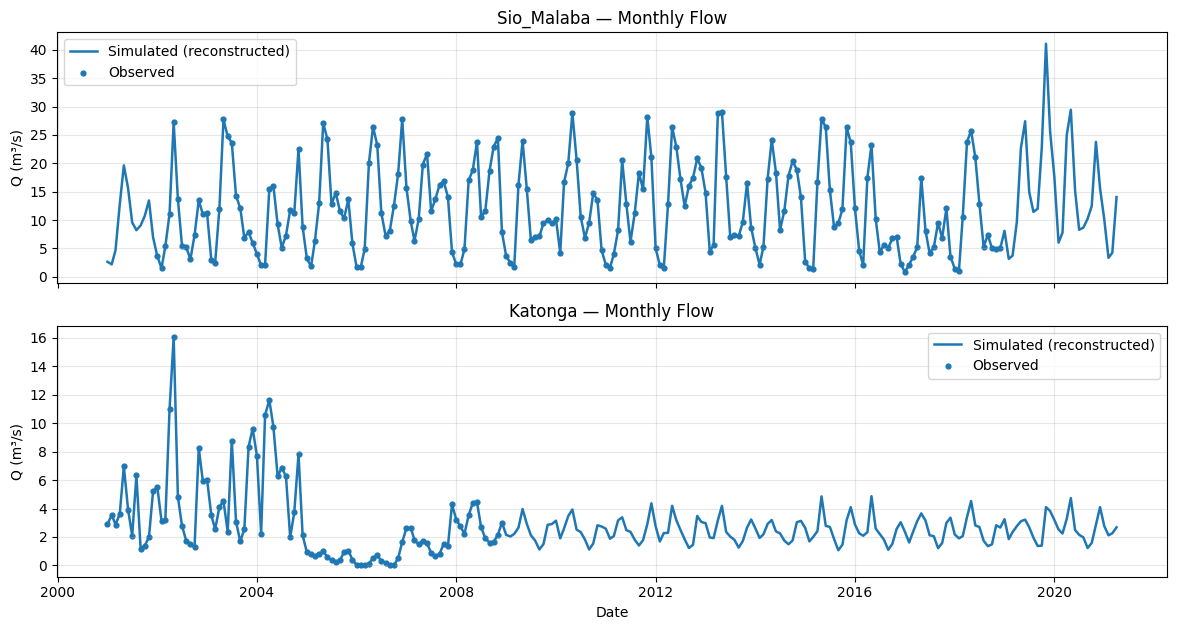

Best: Sio_Malaba | Worst: Katonga


In [16]:
best = perf_df.iloc[0]["tributary"]
worst = perf_df.iloc[-1]["tributary"]

def plot_timeseries_overlay(trib_list: List[str], outpath: Path) -> None:
    """Overlay observed vs simulated monthly flows for selected tributaries."""
    fig, axes = plt.subplots(len(trib_list), 1, figsize=(12, 3.2 * len(trib_list)), sharex=True)
    if len(trib_list) == 1:
        axes = [axes]

    for ax, trib in zip(axes, trib_list):
        y_obs = trib_wide[trib].reindex(monthly_idx)
        y_sim = recon_monthly[trib].reindex(monthly_idx)

        ax.plot(y_sim.index, y_sim.values, label="Simulated (reconstructed)", linewidth=1.8)
        ax.scatter(y_obs.index, y_obs.values, label="Observed", s=12)
        ax.set_title(f"{trib} — Monthly Flow")
        ax.set_ylabel("Q (m³/s)")
        ax.grid(True, alpha=0.3)
        ax.legend()

    axes[-1].set_xlabel("Date")
    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()


plot_timeseries_overlay([best, worst], FIG_DIR / "04_timeseries_obs_vs_sim_best_worst.png")
print("Best:", best, "| Worst:", worst)


### *CELL 12 — Total Qin summary + plot (monthly + daily)*

In [17]:
# Monthly total Qin
qin_monthly = recon_monthly["Qin_total_m3s"].reindex(monthly_idx)

# Daily total Qin (series is likely in first column if saved with name)
qin_daily_series = qin_daily.iloc[:, 0] if qin_daily.shape[1] == 1 else qin_daily["Qin_total_m3s"]
qin_daily_series = qin_daily_series.loc[STUDY_START:STUDY_END]

summary_qin = pd.DataFrame(
    {
        "qin_monthly_mean_m3s": [float(qin_monthly.mean())],
        "qin_monthly_max_m3s": [float(qin_monthly.max())],
        "qin_daily_mean_m3s": [float(qin_daily_series.mean())],
        "qin_daily_max_m3s": [float(qin_daily_series.max())],
    }
)

summary_qin.to_csv(TABLE_DIR / "04_total_qin_summary.csv", index=False)
summary_qin


,qin_monthly_mean_m3s,qin_monthly_max_m3s,qin_daily_mean_m3s,qin_daily_max_m3s
0,651.830521,1758.096195,652.032788,9560.374123


`Now the plots mentioned above`

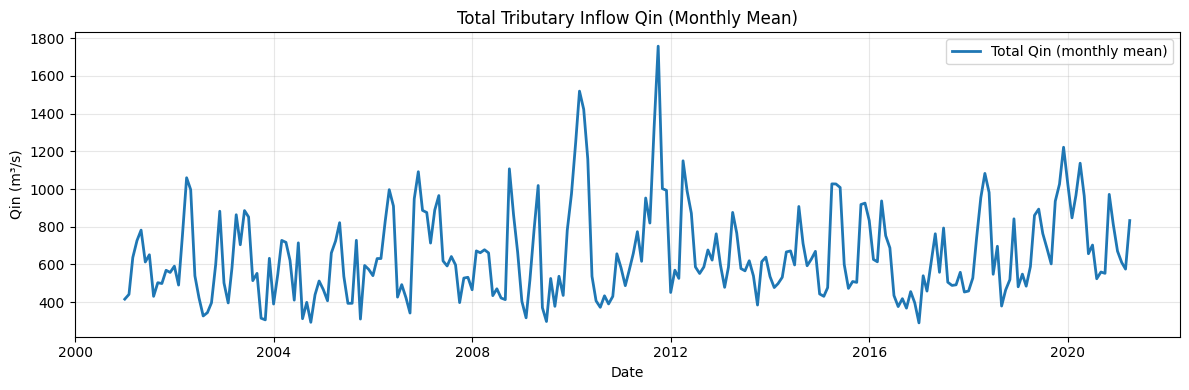

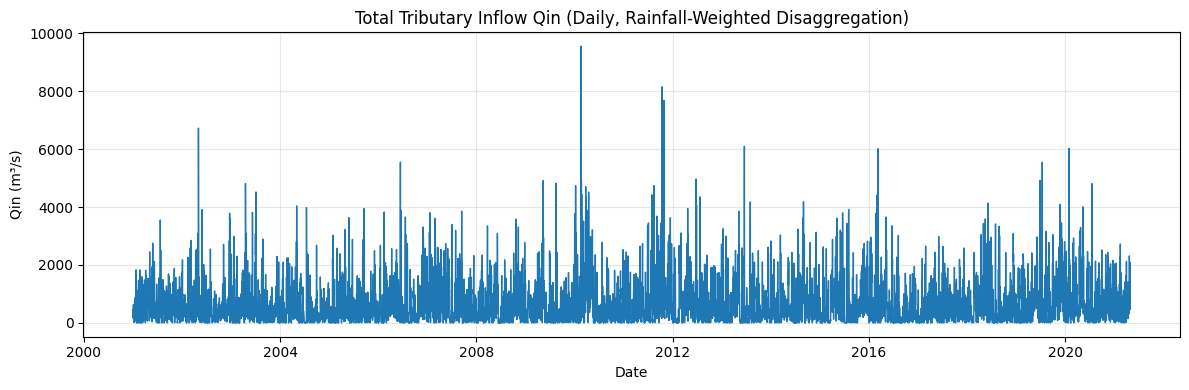

In [18]:
# Plot monthly and daily total Qin
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(qin_monthly.index, qin_monthly.values, label="Total Qin (monthly mean)", linewidth=2)
ax.set_title("Total Tributary Inflow Qin (Monthly Mean)")
ax.set_xlabel("Date")
ax.set_ylabel("Qin (m³/s)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "04_total_qin_monthly.png", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(qin_daily_series.index, qin_daily_series.values, linewidth=1)
ax.set_title("Total Tributary Inflow Qin (Daily, Rainfall-Weighted Disaggregation)")
ax.set_xlabel("Date")
ax.set_ylabel("Qin (m³/s)")
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(FIG_DIR / "04_total_qin_daily.png", dpi=200)
plt.show()


### *CELL 13 — Thesis-ready paragraph for Chapter 4 (Objective 1 Results)*

In [19]:
best_nse = float(perf_df.iloc[0]["nse_test"])
worst_nse = float(perf_df.iloc[-1]["nse_test"])

text = (
    "Tributary inflows were reconstructed for the 2001–2021 study period using rainfall-informed methods. "
    "Twelve tributaries with sufficient overlap between observed flow records and the study window were "
    "modeled using ridge regression with monthly rainfall totals, lagged rainfall, and seasonal terms. "
    "Model evaluation using a time-based train/test split indicated generally good predictive skill, "
    f"with test-period NSE values ranging from {worst_nse:.2f} to {best_nse:.2f} across trainable tributaries. "
    "Three tributaries (Nyando, Nzoia and Yala) lacked overlap with the study period and were represented "
    "using historical monthly climatology scaled by rainfall anomalies. The resulting continuous inflow series "
    "provided a consistent tributary inflow term (Qin) for the Lake Victoria water balance and outflow optimization analyses."
)

(TABLE_DIR / "04_objective1_results_paragraph.txt").write_text(text, encoding="utf-8")
print(text)


Tributary inflows were reconstructed for the 2001–2021 study period using rainfall-informed methods. Twelve tributaries with sufficient overlap between observed flow records and the study window were modeled using ridge regression with monthly rainfall totals, lagged rainfall, and seasonal terms. Model evaluation using a time-based train/test split indicated generally good predictive skill, with test-period NSE values ranging from -0.96 to 0.59 across trainable tributaries. Three tributaries (Nyando, Nzoia and Yala) lacked overlap with the study period and were represented using historical monthly climatology scaled by rainfall anomalies. The resulting continuous inflow series provided a consistent tributary inflow term (Qin) for the Lake Victoria water balance and outflow optimization analyses.
